In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
series = pd.read_csv('water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 10
trainset, validation = series[0:split_point], series[split_point:]
print('trainset %d, Validation %d' % (len(trainset), len(validation)))
trainset.to_csv('trainset.csv', header=False)
validation.to_csv('validation.csv', header=False)

trainset 69, Validation 10


In [3]:
s1 = pd.read_csv('trainset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
s1.describe()

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: 1, dtype: float64

<AxesSubplot:xlabel='0'>

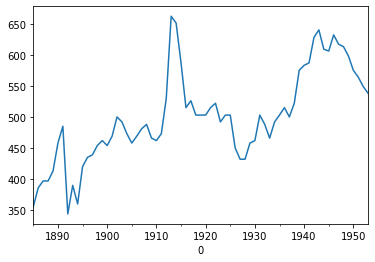

In [4]:
s1.plot()

<AxesSubplot:ylabel='Density'>

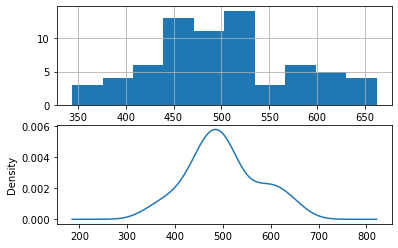

In [5]:
fig, ax=plt.subplots(2, sharex=False)
s1.hist(ax=ax[0], legend=None)
s1.plot(ax=ax[1], legend=None, kind='kde')

<AxesSubplot:>

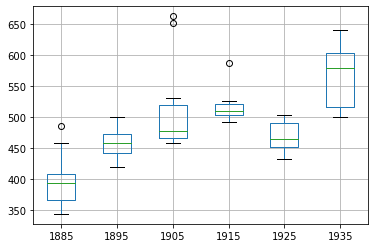

In [6]:
groups = s1.groupby(pd.Grouper(freq='10YS'))
decades = pd.DataFrame()
for name, group in groups:
    if len(group.values) == 10:
        decades[name.year] = group.values
decades.boxplot()

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values: 
	1%: -3.534
	5%: -2.906
	10%: -2.591


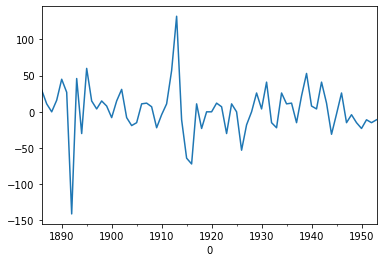

In [7]:
#create and summarize a stationary version of time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

#create a difference serise
def difference(trainset):
    diff = list()
    for i in range(1, len(trainset)):
        value = trainset[i]-trainset[i-1]
        diff.append(value)
    return pd.Series(diff)

X = s1.values
X = X.astype('float32')
stationary = difference(X)
stationary.index = s1.index[1:]
result = adfuller(stationary)
print('ADF Statistic: %f'% result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' %(key, value))
stationary.plot()
stationary.to_csv('stationary.csv', header=False)

#### <span style='color:Black'> this suggest that at least one level of differecing is required. the d parameter is our ARIMA model should at least be a value of 1.

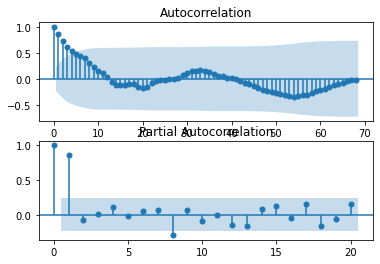

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(s1, lags=68, ax=plt.gca())
plt.subplot(212)
plot_pacf(s1, lags=20, method='ywm', ax=plt.gca())
plt.show()

In [9]:
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

In [10]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(4,1,1))
    output = model.fit().forecast()
    yhat = output[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('Predicted=%.3f, Observed=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

Predicted=571.332, Observed=583.000
Predicted=568.102, Observed=587.000
Predicted=567.410, Observed=628.000
Predicted=620.638, Observed=640.000
Predicted=632.546, Observed=609.000
Predicted=594.338, Observed=606.000
Predicted=602.108, Observed=632.000
Predicted=637.227, Observed=617.000
Predicted=614.318, Observed=613.000
Predicted=608.755, Observed=598.000
Predicted=600.294, Observed=575.000
Predicted=574.946, Observed=564.000
Predicted=567.577, Observed=549.000
Predicted=553.543, Observed=538.000
RMSE: 23.899


In [11]:
import warnings

In [12]:
# grid search ARIMA hyperparameters
# evaluate an ARIMA model for a given order(p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        output = model.fit().forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combination of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try: 
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
series = pd.read_csv('trainset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings('ignore')
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=76.755
ARIMA(0, 0, 1) RMSE=47.347
ARIMA(0, 0, 2) RMSE=36.030
ARIMA(0, 0, 3) RMSE=32.537
ARIMA(0, 0, 4) RMSE=29.516
ARIMA(0, 1, 0) RMSE=21.975
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(1, 1, 1) RMSE=21.879
ARIMA(2, 1, 0) RMSE=21.732
Best ARIMA(2, 1, 0) RMSE=21.732


In [13]:
# summarize residual errors for the ARIMA model
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    output = model.fit().forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)

residuals = [test[i]-predictions[i] for i in range(len(test))]
df_res = pd.DataFrame(residuals)
df_res.describe()

,0
count,35.000000
mean,1.081458
std,22.022201
min,-52.104849
25%,-16.209637
50%,-0.454858
75%,12.089062
max,51.281127


<AxesSubplot:ylabel='Density'>

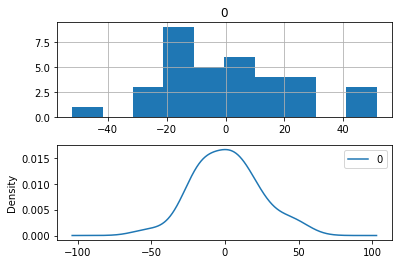

In [14]:
fig, ax = plt.subplots(2)
df_res.hist(ax=ax[0])
df_res.plot(kind='kde', ax=ax[1])

#### <span style='color:Black'> the distribution of residual errors suggest a Gaussian-like shape.

In [15]:
# save finalized model to file
model = ARIMA(X, order=(2,1,0))
bias = 1.081458
model.fit().save('model.pkl')
np.save('model_bias.npy', [bias])

In [16]:
# load finalized model and make a prediction
from statsmodels.tsa.arima_model import ARIMAResults
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 540.011


>Predicted=540.011, Actual=568.000
>Predicted=571.593, Actual=575.000
>Predicted=573.292, Actual=579.000
>Predicted=579.561, Actual=587.000
>Predicted=588.064, Actual=602.000
>Predicted=603.025, Actual=594.000
>Predicted=593.177, Actual=587.000
>Predicted=588.556, Actual=587.000
>Predicted=588.796, Actual=625.000
>Predicted=627.947, Actual=613.000
RMSE: 16.533


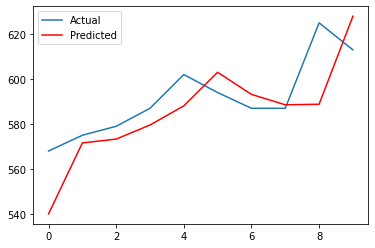

In [17]:
# load and evaluate the finalized model on the validation dataset
trainset = pd.read_csv('trainset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = trainset.values.astype('float32')
history = [x for x in X]
valiset = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = valiset.values.astype('float32')
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Actual=%.3f' % (yhat, y[0]))
# rolling forecast
for i in range(1, len(y)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat) 
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Actual=%.3f' % (yhat, obs))
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red')
plt.legend(['Actual', 'Predicted'])